In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import os
import sys
from pathlib import Path
from zipfile import ZipFile

PROJ_ROOT = Path(os.getcwd()).parent.parent 
sys.path.append(str(PROJ_ROOT)) # add project root file to the python paths

In [3]:
data_path = PROJ_ROOT / 'data' / 'raw'

# Data Availability

Trade data is available for the period: **01**.06.2018 - 30.09.2018 and it is stored as `bitstamp_trx_DD_MM_2018.zip`

Order book data is available for the period: **05**.06.2018 - 30.09.2018 and it is stored as `bitstamp_ob_DD_MM_2018.zip`



Trade data files are ~1Mb per file (per day).

OB data ~150Mb per zip file, and around 650Mb unzipped. 

We will treat them in the EDA separately and only merge them in the final step of the preprocessing.


# Order book data

## Load and format

### Time loading and unpacking

In [5]:
ob_sample = pd.read_csv(
     data_path / 'bitstamp_ob_05_06_2018.zip'   
)

Pandas takes around 10s per file to unzip and load into a dataframe. We expect around 2.5 hours only for loading the data. We will use polars for this task.

In [ ]:
with ZipFile(data_path / 'bitstamp_ob_05_06_2018.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [ ]:
pl.read_csv(
    ZipFile(data_path / 'bitstamp_ob_05_06_2018.zip').read("bitstamp_ob_05_06_2018.csv")
)

In [ ]:
pl.read_csv(
    data_path / 'bitstamp_ob_05_06_2018.csv'
)

time,type,price,amount
i64,str,f64,f64
1528149602,"""b""",7537.0,3.227621
1528149602,"""b""",7535.15,0.1389
1528149602,"""b""",7532.5,0.4056
1528149602,"""b""",7531.73,0.2
1528149602,"""b""",7530.02,0.3
…,…,…,…
1528235974,"""a""",15084.0,0.076
1528235974,"""a""",15087.0,0.02
1528235974,"""a""",15088.0,0.0744


Polars takes 4.5s per file to unzip and load into a dataframe. Unzip to disk takes ~2.5s, reading csv ~1s. 

Given the limited disk space, we will 

## Compute features

> 05/06 is an example of a day without extremely large orders

> 21/06 is an example of a day when a few very big bid orders which are totally changing the correlation matrix and

> 15/08 is an example of a day with strong drift in the order book features

Conclusions at the end of this subsection are given by making observations on the example days. 

In [36]:
ob_sample = pl.read_csv(
    ZipFile(data_path / 'bitstamp_ob_05_06_2018.zip').read("bitstamp_ob_05_06_2018.csv")
)

In [37]:
# ob_sample = pl.read_csv(
#     ZipFile(data_path / 'bitstamp_ob_21_06_2018.zip').read("bitstamp_ob_21_06_2018.csv")
# )

In [38]:
ob_sample = ob_sample.with_columns(
    (pl.col('type') == 'b').alias('is_bid')
).drop('type')

In [39]:
ob_sample

time,price,amount,is_bid
i64,f64,f64,bool
1528149602,7537.0,3.227621,true
1528149602,7535.15,0.1389,true
1528149602,7532.5,0.4056,true
1528149602,7531.73,0.2,true
1528149602,7530.02,0.3,true
…,…,…,…
1528235974,15084.0,0.076,false
1528235974,15087.0,0.02,false
1528235974,15088.0,0.0744,false


OB data consist of individual orders with associated `time`. Time is ticking with minute frequency, and we will form order book features by computing statistics in the aggregation window of 1 minute, i.e. by grouping by `time`.

In [40]:
ob_desc = ob_sample.with_columns(
    pl.when(pl.col('is_bid'))
    .then(pl.col('price'))
    .otherwise(None)
    .alias('bid_price'),
    pl.when(~pl.col('is_bid'))
    .then(pl.col('price'))
    .otherwise(None)
    .alias('ask_price'),
)

ob_desc.describe()


statistic,time,price,amount,is_bid,bid_price,ask_price
str,f64,f64,f64,f64,f64,f64
"""count""",2.4475306e7,2.4475306e7,2.4475306e7,2.4475306e7,1.0075306e7,1.44e7
"""null_count""",0.0,0.0,0.0,0.0,1.44e7,1.0075306e7
"""mean""",1.5282e9,7956.449587,69.308443,0.411652,4567.823124,10327.383512
"""std""",24982.877102,3490.528417,3268.343835,null,2323.384671,1809.975121
"""min""",1.5281e9,0.01,3.0000e-8,0.0,0.01,7361.53
"""25%""",1.5282e9,6000.0,0.002937,null,2921.0,9189.73
"""50%""",1.5282e9,8580.45,0.05,null,5261.0,9822.95
"""75%""",1.5282e9,9934.75,0.3803,null,6530.0,11489.0
"""max""",1.5282e9,15327.0,268634.1292,1.0,7665.0,15327.0


### Inspect Single Timestamp

In [41]:
ob_sample

time,price,amount,is_bid
i64,f64,f64,bool
1528149602,7537.0,3.227621,true
1528149602,7535.15,0.1389,true
1528149602,7532.5,0.4056,true
1528149602,7531.73,0.2,true
1528149602,7530.02,0.3,true
…,…,…,…
1528235974,15084.0,0.076,false
1528235974,15087.0,0.02,false
1528235974,15088.0,0.0744,false


In [42]:
# inspect a single timestamp
timestamp = np.random.choice(ob_sample['time'].unique(), size=1, replace=False) 
ob_single_ts = ob_sample.filter(
    pl.col('time') == timestamp[0])
ob_single_ts

time,price,amount,is_bid
i64,f64,f64,bool
1528180142,7425.19,1.53,true
1528180142,7424.9,0.8002,true
1528180142,7424.62,0.01,true
1528180142,7421.74,1.0,true
1528180142,7420.86,7.065849,true
…,…,…,…
1528180142,14666.0,0.01,false
1528180142,14667.0,0.286,false
1528180142,14667.7,0.002359,false


#### Accumulated Price (price * amount)

In [43]:
bid_acc = ob_single_ts.sort(by='price', descending=True).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(pl.col('is_bid'))
    .then(pl.col('amount ')*pl.col('price'))
    .otherwise(None)
    .alias('accumulated_bid'),
).drop_nulls(subset=['accumulated_bid']
).with_columns(
    pl.col('accumulated_bid').cum_sum().alias('accumulated_bid'),
)

In [44]:
bid_acc

price,amount,is_bid,accumulated_bid
f64,f64,bool,f64
7425.19,1.53,true,11360.5407
7424.9,0.8002,true,17301.94568
7424.62,0.01,true,17376.19188
7421.74,1.0,true,24797.93188
7420.86,7.065849,true,77232.60809
…,…,…,…
0.05,10500.0,true,6.4899e7
0.04,1000.0,true,6.4899e7
0.03,12500.0,true,6.4900e7


In [45]:
ask_acc = ob_single_ts.sort(by='price', descending=False).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(~pl.col('is_bid'))
    .then(pl.col('amount ')*pl.col('price'))
    .otherwise(None)
    .alias('accumulated_ask'),
).drop_nulls(subset=['accumulated_ask']
).with_columns(
    pl.col('accumulated_ask').cum_sum().alias('accumulated_ask'),
)

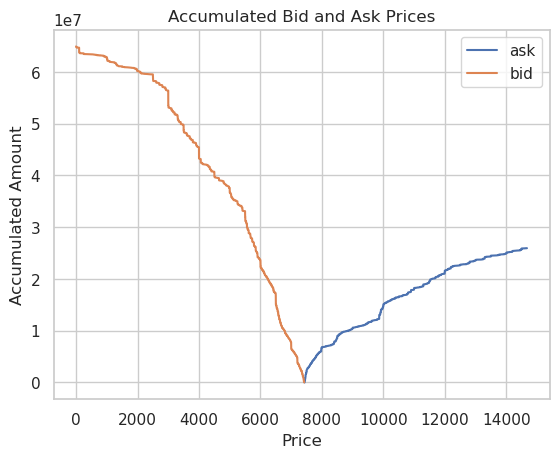

In [ ]:
# plot bid and ask prices

sns.lineplot(ask_acc, x='price', y='accumulated_ask', label='ask')
sns.lineplot(bid_acc, x='price', y='accumulated_bid', label='bid')
plt.xlabel('Price')
plt.ylabel('Accumulated Amount')
plt.title('Accumulated Bid and Ask Prices')
plt.legend()
plt.show()

In [47]:
def make_ts_example(timestamp:int):
    ob_single_ts = ob_sample.filter(
    pl.col('time') == timestamp)

    bid_acc = ob_single_ts.sort(by='price', descending=True).select(
        pl.col('price'),
        pl.col('amount '),
        pl.col('is_bid')
    ).with_columns(
        pl.when(pl.col('is_bid'))
        .then(pl.col('amount ')*pl.col('price'))
        .otherwise(None)
        .alias('accumulated_bid'),
    ).drop_nulls(subset=['accumulated_bid']
    ).with_columns(
        pl.col('accumulated_bid').cum_sum().alias('accumulated_bid'),
    )

    ask_acc = ob_single_ts.sort(by='price', descending=False).select(
        pl.col('price'),
        pl.col('amount '),
        pl.col('is_bid')
    ).with_columns(
        pl.when(~pl.col('is_bid'))
        .then(pl.col('amount ')*pl.col('price'))
        .otherwise(None)
        .alias('accumulated_ask'),
    ).drop_nulls(subset=['accumulated_ask']
    ).with_columns(
        pl.col('accumulated_ask').cum_sum().alias('accumulated_ask'),
    )

    return bid_acc.to_pandas(), ask_acc.to_pandas()



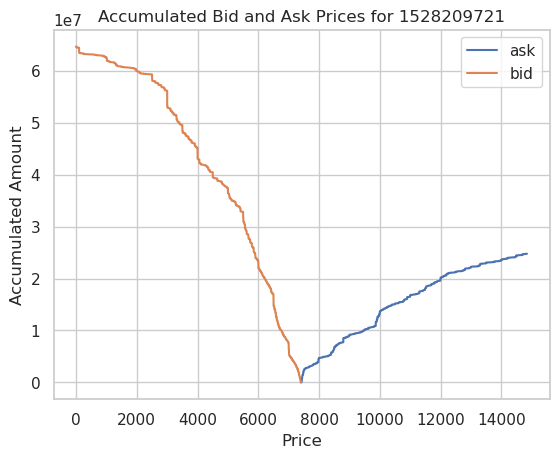

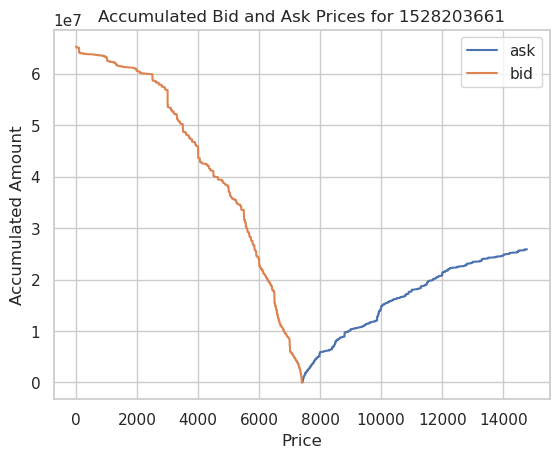

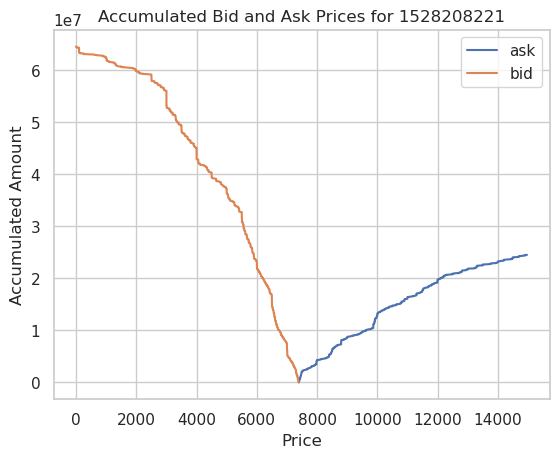

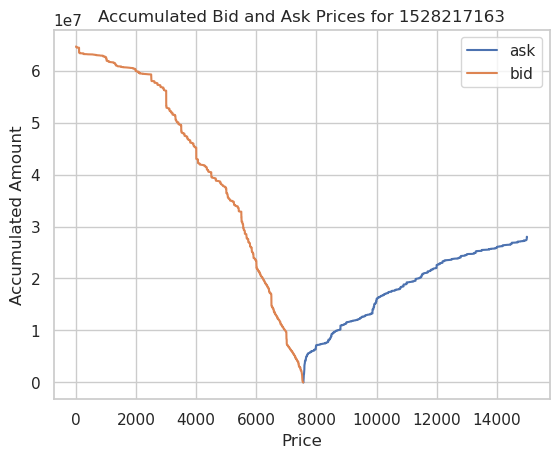

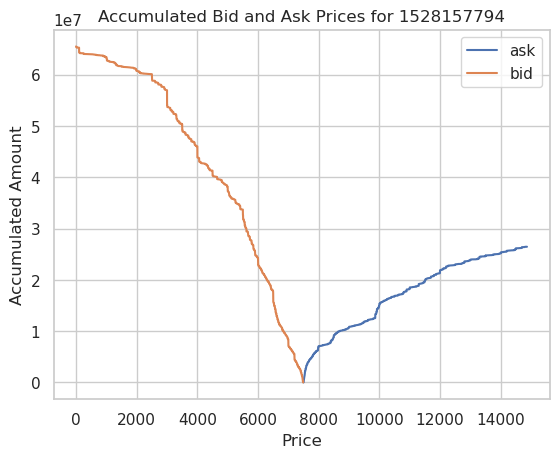

In [48]:
timestamps = np.random.choice(ob_sample['time'].unique(), size=5, replace=False) 


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example(ts)
    sns.lineplot(ask_acc, x='price', y='accumulated_ask', label='ask')
    sns.lineplot(bid_acc, x='price', y='accumulated_bid', label='bid')
    plt.xlabel('Price')
    plt.ylabel('Accumulated Amount')
    plt.title(f'Accumulated Bid and Ask Prices for {ts}')
    plt.legend()
    plt.show()

Visually, different timestamps have very similar distributions of orders, which is expected for such a high frequency of sampling.

#### Accumulated Depth (count of orders)

In [ ]:
bid_acc_vol = ob_single_ts.sort(by='price', descending=True).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(pl.col('is_bid'))
    .then(pl.col('amount '))
    .otherwise(None)
    .alias('accumulated_bid'),
).drop_nulls(subset=['accumulated_bid']
).with_columns(
    pl.col('accumulated_bid').cum_sum().alias('accumulated_bid'),
)

In [ ]:
ask_acc_vol = ob_single_ts.sort(by='price', descending=False).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(~pl.col('is_bid'))
    .then(pl.col('amount '))
    .otherwise(None)
    .alias('accumulated_ask'),
).drop_nulls(subset=['accumulated_ask']
).with_columns(
    pl.col('accumulated_ask').cum_sum().alias('accumulated_ask'),
)

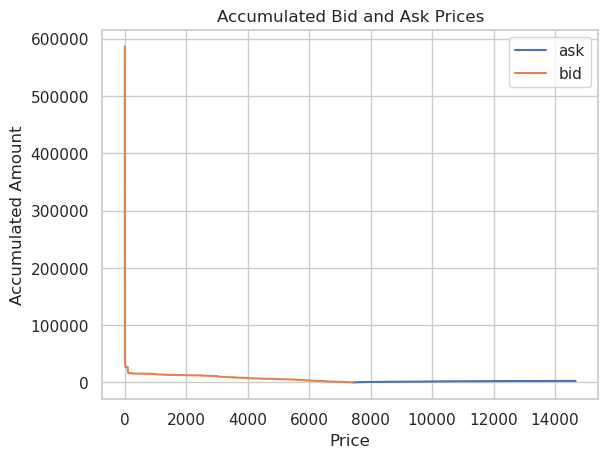

In [ ]:
# plot bid and ask prices

sns.lineplot(ask_acc_vol, x='price', y='accumulated_ask', label='ask')
sns.lineplot(bid_acc_vol, x='price', y='accumulated_bid', label='bid')
plt.xlabel('Price')
plt.ylabel('Accumulated Amount')
plt.title('Accumulated Bid and Ask Prices')
plt.legend()
plt.show()

We will filter out bit orders with prices less then USD 100

In [ ]:
bid_acc_vol = ob_single_ts.sort(by='price', descending=True).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(pl.col('is_bid') & (pl.col('price') > 100.0)) ### FILTER
    .then(pl.col('amount '))
    .otherwise(None)
    .alias('accumulated_bid'),
).drop_nulls(subset=['accumulated_bid']
).with_columns(
    pl.col('accumulated_bid').cum_sum().alias('accumulated_bid'),
)

In [82]:
ask_acc_vol = ob_single_ts.sort(by='price', descending=False).select(
    pl.col('price'),
    pl.col('amount '),
    pl.col('is_bid')
).with_columns(
    pl.when(~pl.col('is_bid'))
    .then(pl.col('amount '))
    .otherwise(None)
    .alias('accumulated_ask'),
).drop_nulls(subset=['accumulated_ask']
).with_columns(
    pl.col('accumulated_ask').cum_sum().alias('accumulated_ask'),
)

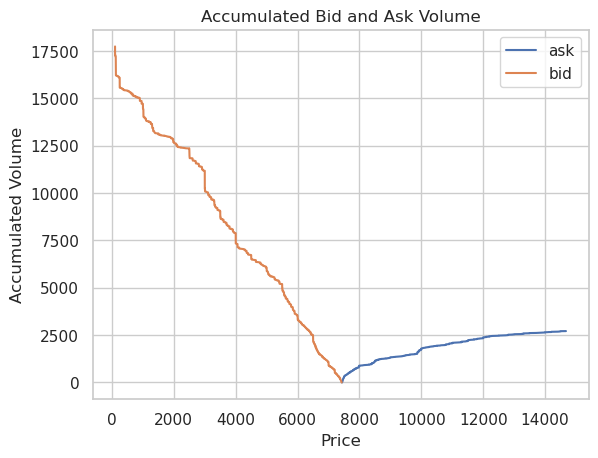

In [84]:
# plot bid and ask prices

sns.lineplot(ask_acc_vol, x='price', y='accumulated_ask', label='ask')
sns.lineplot(bid_acc_vol, x='price', y='accumulated_bid', label='bid')
plt.xlabel('Price')
plt.ylabel('Accumulated Volume')
plt.title('Accumulated Bid and Ask Volume')
plt.legend()
plt.show()

In [88]:
def make_ts_example_acc_vol_filtered(timestamp:int):
    ob_single_ts = ob_sample.filter(
    pl.col('time') == timestamp)

    bid_acc = ob_single_ts.sort(by='price', descending=True).select(
        pl.col('price'),
        pl.col('amount '),
        pl.col('is_bid')
    ).with_columns(
        pl.when(pl.col('is_bid' ) & (pl.col('price') > 100.0)) ### FILTER
        .then(pl.col('amount '))
        .otherwise(None)
        .alias('accumulated_bid'),
    ).drop_nulls(subset=['accumulated_bid']
    ).with_columns(
        pl.col('accumulated_bid').cum_sum().alias('accumulated_bid'),
    )

    ask_acc = ob_single_ts.sort(by='price', descending=False).select(
        pl.col('price'),
        pl.col('amount '),
        pl.col('is_bid')
    ).with_columns(
        pl.when(~pl.col('is_bid'))
        .then(pl.col('amount '))
        .otherwise(None)
        .alias('accumulated_ask'),
    ).drop_nulls(subset=['accumulated_ask']
    ).with_columns(
        pl.col('accumulated_ask').cum_sum().alias('accumulated_ask'),
    )

    return bid_acc.to_pandas(), ask_acc.to_pandas()



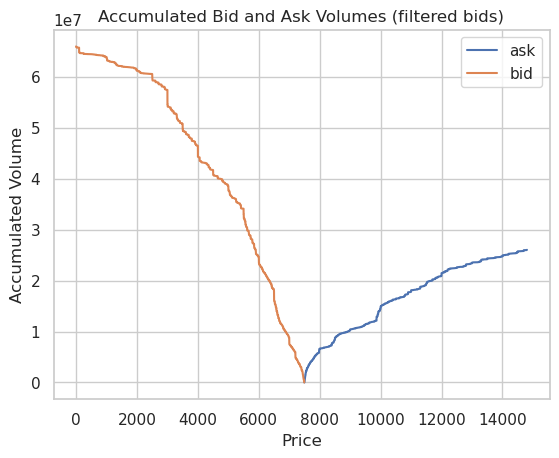

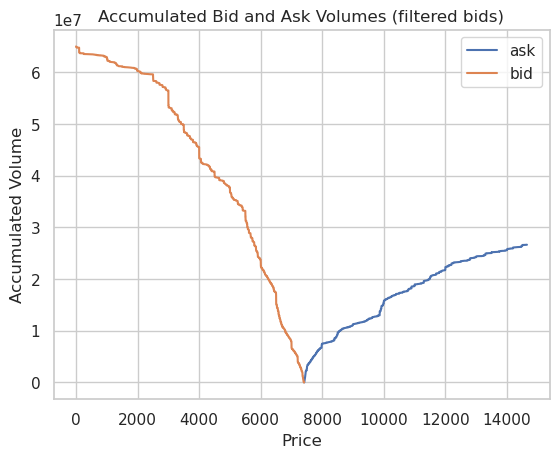

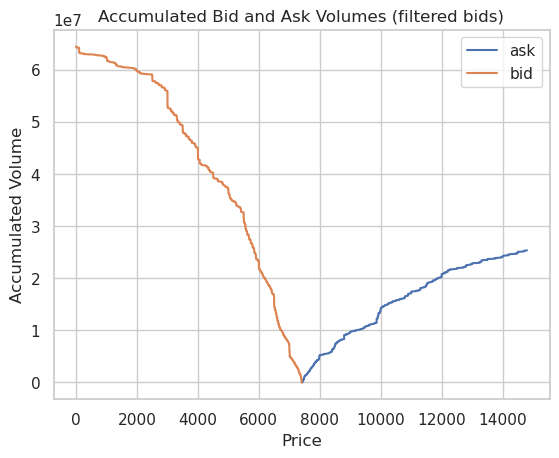

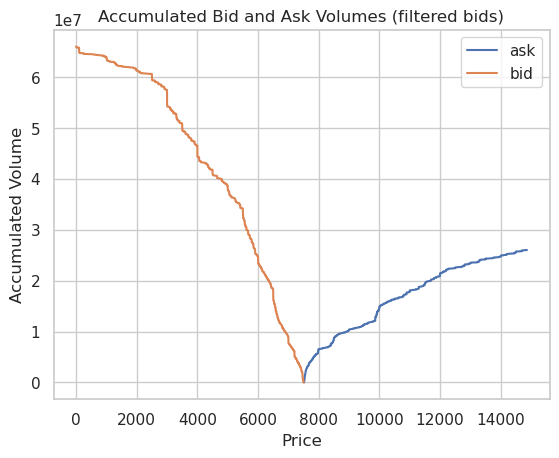

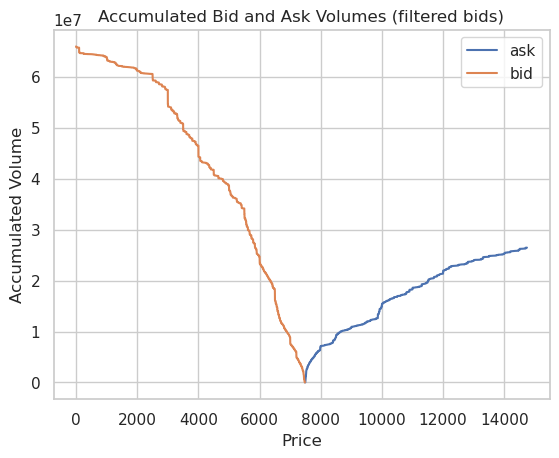

In [93]:
timestamps = np.random.choice(ob_sample['time'].unique(), size=5, replace=False) 


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example(ts)
    sns.lineplot(ask_acc, x='price', y='accumulated_ask', label='ask')
    sns.lineplot(bid_acc, x='price', y='accumulated_bid', label='bid')
    plt.xlabel('Price')
    plt.ylabel('Accumulated Volume')
    plt.title(f'Accumulated Bid and Ask Volumes (filtered bids)')
    plt.legend()
    plt.show()

Accumulated depth is the number of orders in the order book, and it is 

### Compute: Volume, depth and spread 

In [49]:
time_agg = ob_sample.group_by(['time']).agg(
    pl.when(pl.col('is_bid')).then(pl.col('amount ')).otherwise(None).sum().alias('bid_volume'),
    pl.when(~pl.col('is_bid')).then(pl.col('amount ')).otherwise(None).sum().alias('ask_volume'),
    pl.when(pl.col('is_bid')).then(pl.col('price')).otherwise(None).max().alias('max_bid'),
    pl.when(~pl.col('is_bid')).then(pl.col('price')).otherwise(None).min().alias('min_ask'),
    pl.when(pl.col('is_bid')).then(pl.col('price')).otherwise(None).count().alias('bid_depth'),
    pl.when(~pl.col('is_bid')).then(pl.col('price')).otherwise(None).count().alias('ask_depth'),
).cast(
    {
        'bid_depth': pl.Int32,
        'ask_depth': pl.Int32
    }
).sort('time')
time_agg

time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth
i64,f64,f64,f64,f64,i32,i32
1528149602,586356.113693,2695.804973,7537.0,7543.19,3510,5000
1528149634,586351.269401,2696.561478,7537.0,7543.19,3510,5000
1528149661,586350.938081,2699.165417,7537.0,7541.97,3510,5000
1528149693,586307.355517,2656.934508,7537.01,7541.97,3508,5000
1528149722,586317.596946,2657.946212,7537.0,7541.9,3509,5000
…,…,…,…,…,…,…
1528235853,586359.535387,2639.309888,7585.02,7587.61,3560,5000
1528235881,586349.559794,2640.391771,7586.33,7589.52,3557,5000
1528235914,586359.035472,2639.944562,7586.41,7589.52,3557,5000


Let's calculate `spread`, `volume_diff` and `depth_diff`.

In [50]:
time_agg = time_agg.with_columns(
    (pl.col('ask_depth')-pl.col('bid_depth')).alias('depth_diff'),
    (pl.col('min_ask')-pl.col('max_bid')).alias('spread'), 
    (pl.col('bid_volume') - pl.col('ask_volume')).alias('volume_diff'), # bid_vol is always larger
)
time_agg

time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth,depth_diff,spread,volume_diff
i64,f64,f64,f64,f64,i32,i32,i32,f64,f64
1528149602,586356.113693,2695.804973,7537.0,7543.19,3510,5000,1490,6.19,583660.30872
1528149634,586351.269401,2696.561478,7537.0,7543.19,3510,5000,1490,6.19,583654.707923
1528149661,586350.938081,2699.165417,7537.0,7541.97,3510,5000,1490,4.97,583651.772664
1528149693,586307.355517,2656.934508,7537.01,7541.97,3508,5000,1492,4.96,583650.421009
1528149722,586317.596946,2657.946212,7537.0,7541.9,3509,5000,1491,4.9,583659.650734
…,…,…,…,…,…,…,…,…,…
1528235853,586359.535387,2639.309888,7585.02,7587.61,3560,5000,1440,2.59,583720.225499
1528235881,586349.559794,2640.391771,7586.33,7589.52,3557,5000,1443,3.19,583709.168023
1528235914,586359.035472,2639.944562,7586.41,7589.52,3557,5000,1443,3.11,583719.09091


### Compute: Weighted spread and Slopes

Following are descriptions from the paper
- **Ask/bid slope**: Volume until $\delta$ price, where $\delta_{ask}$ is 10th quantile of the asks and $\delta_{bid}$ is 90th quantile of the bids.
- **Weighted spread**: "difference between cumulative price over 10% of bid depth and cumulative price over 10% of ask depth". This means that we will filter bid orders larger then $\delta_{bid}$, and ask orders smaller then $\delta_{ask}$. Then we will compute the cumulative price over the filtered orders.

In [51]:
# aggregate data over the 10th "percentiles" 
time_quantile_agg = ob_sample.group_by(['time']).agg(
    pl.when(pl.col('is_bid')).then(pl.col('price')).otherwise(None).quantile(0.9).alias('bid_delta'),
    pl.when(~pl.col('is_bid')).then(pl.col('price')).otherwise(None).quantile(0.1).alias('ask_delta'),
)
time_quantile_agg

time,bid_delta,ask_delta
i64,f64,f64
1528215334,7099.0,8264.42
1528152001,7103.9,8165.0
1528169341,7030.57,8109.67
1528175614,7025.0,8088.0
1528200242,7016.0,8166.07
…,…,…
1528213321,7051.0,8138.77
1528160733,7107.41,8177.03
1528198113,7025.0,8154.0


In [52]:
ob_tq_agg = pl.concat(
    [ob_sample, time_quantile_agg],
    how='align_right'
)
ob_tq_agg

time,price,amount,is_bid,bid_delta,ask_delta
i64,f64,f64,bool,f64,f64
1528149602,7537.0,3.227621,true,7100.29,8210.0
1528149602,7535.15,0.1389,true,7100.29,8210.0
1528149602,7532.5,0.4056,true,7100.29,8210.0
1528149602,7531.73,0.2,true,7100.29,8210.0
1528149602,7530.02,0.3,true,7100.29,8210.0
…,…,…,…,…,…
1528235974,15084.0,0.076,false,7140.08,8279.0
1528235974,15087.0,0.02,false,7140.08,8279.0
1528235974,15088.0,0.0744,false,7140.08,8279.0


In [53]:

ob_tq_agg.filter(
    pl.col('time') == timestamp[0]
)

time,price,amount,is_bid,bid_delta,ask_delta
i64,f64,f64,bool,f64,f64
1528180142,7425.19,1.53,true,7040.0,8104.47
1528180142,7424.9,0.8002,true,7040.0,8104.47
1528180142,7424.62,0.01,true,7040.0,8104.47
1528180142,7421.74,1.0,true,7040.0,8104.47
1528180142,7420.86,7.065849,true,7040.0,8104.47
…,…,…,…,…,…
1528180142,14666.0,0.01,false,7040.0,8104.47
1528180142,14667.0,0.286,false,7040.0,8104.47
1528180142,14667.7,0.002359,false,7040.0,8104.47


In [54]:
time_agg_weighted = pl.concat(
    [ob_sample, time_quantile_agg],
    how='align_right'
).group_by(['time']).agg(
    pl.when(pl.col('is_bid') & (pl.col('price') >= pl.col('bid_delta'))).then(pl.col('amount ')).otherwise(0.0).sum().alias('bid_slope'),
    pl.when(~pl.col('is_bid') & (pl.col('price') <= pl.col('ask_delta'))).then(pl.col('amount ')).otherwise(0.0).sum().alias('ask_slope'),
    pl.when(pl.col('is_bid') & (pl.col('price') >= pl.col('bid_delta'))).then(pl.col('price')).otherwise(None).min().alias('weighted_bid'),
    pl.when(~pl.col('is_bid') & (pl.col('price') <= pl.col('ask_delta'))).then(pl.col('price')).otherwise(None).max().alias('weighted_ask'),
).with_columns(
    (pl.col('weighted_ask') - pl.col('weighted_bid')).alias('weighted_spread'),
)
time_agg_weighted

time,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
i64,f64,f64,f64,f64,f64
1528149602,934.466054,868.789883,7100.29,8210.0,1109.71
1528149634,929.621762,869.597349,7100.29,8204.47,1104.18
1528149661,929.290442,872.151288,7100.29,8203.44,1103.15
1528149693,894.15346,829.919417,7099.0,8210.0,1111.0
1528149722,903.394889,830.982083,7100.0,8204.47,1104.47
…,…,…,…,…,…
1528235853,1008.843487,711.932457,7140.08,8284.42,1144.34
1528235881,1003.168735,713.01434,7134.59,8284.42,1149.83
1528235914,1003.242941,712.566581,7134.59,8286.62,1152.03


In [55]:
agg_df = pl.concat(
    [time_agg, time_agg_weighted],
    how='align'
).sort('time')
agg_df

time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth,depth_diff,spread,volume_diff,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
i64,f64,f64,f64,f64,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
1528149602,586356.113693,2695.804973,7537.0,7543.19,3510,5000,1490,6.19,583660.30872,934.466054,868.789883,7100.29,8210.0,1109.71
1528149634,586351.269401,2696.561478,7537.0,7543.19,3510,5000,1490,6.19,583654.707923,929.621762,869.597349,7100.29,8204.47,1104.18
1528149661,586350.938081,2699.165417,7537.0,7541.97,3510,5000,1490,4.97,583651.772664,929.290442,872.151288,7100.29,8203.44,1103.15
1528149693,586307.355517,2656.934508,7537.01,7541.97,3508,5000,1492,4.96,583650.421009,894.15346,829.919417,7099.0,8210.0,1111.0
1528149722,586317.596946,2657.946212,7537.0,7541.9,3509,5000,1491,4.9,583659.650734,903.394889,830.982083,7100.0,8204.47,1104.47
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1528235853,586359.535387,2639.309888,7585.02,7587.61,3560,5000,1440,2.59,583720.225499,1008.843487,711.932457,7140.08,8284.42,1144.34
1528235881,586349.559794,2640.391771,7586.33,7589.52,3557,5000,1443,3.19,583709.168023,1003.168735,713.01434,7134.59,8284.42,1149.83
1528235914,586359.035472,2639.944562,7586.41,7589.52,3557,5000,1443,3.11,583719.09091,1003.242941,712.566581,7134.59,8286.62,1152.03


## Inspect features

In [56]:
agg_df.describe()

statistic,time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth,depth_diff,spread,volume_diff,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.5282e9,586312.877728,2695.927651,7479.445344,7483.919778,3498.370139,5000.0,1501.629861,4.474434,583616.950077,901.909099,830.931471,7070.116542,8164.870132,1094.75359
"""std""",24945.947957,141.224397,88.324994,78.922648,79.05539,41.794289,0.0,41.794289,2.651205,170.304311,160.707438,120.887987,48.060795,64.537974,35.790805
"""min""",1.5281e9,585993.797821,2384.17565,7360.0,7361.53,3400.0,5000.0,1408.0,0.01,583299.960828,643.821696,461.480411,6988.89,8042.9,1018.2
"""25%""",1.5282e9,586221.286234,2624.750828,7416.17,7420.77,3466.0,5000.0,1477.0,2.38,583500.46742,789.953288,718.875981,7029.7,8111.0,1064.7
"""50%""",1.5282e9,586272.514858,2699.206862,7440.65,7443.18,3481.0,5000.0,1519.0,4.52,583571.006363,881.321972,853.690674,7050.0,8146.0,1087.7
"""75%""",1.5282e9,586362.613259,2761.784055,7542.87,7543.26,3523.0,5000.0,1534.0,6.28,583675.22974,947.907371,942.266062,7103.74,8210.0,1125.26
"""max""",1.5282e9,586715.859347,2910.649491,7665.0,7669.86,3592.0,5000.0,1600.0,16.41,584182.254651,1379.253628,1078.858034,7181.0,8400.9,1287.31


The number of ask quotes was probably limited to 5000 during the fetching of the data. **TODO:** check that!

For this reason, `ask_depth` is always 5000, and `bid_depth` will be equal to `depth_diff`+5000, thus **we expect the following features to be redundant**:
- **ask_depth**, as it is equal to 5000
- **depth_diff**, as it is equal to `bid_depth` - 5000

### Where are $\delta_{ask}$ and $\delta_{bid}$?

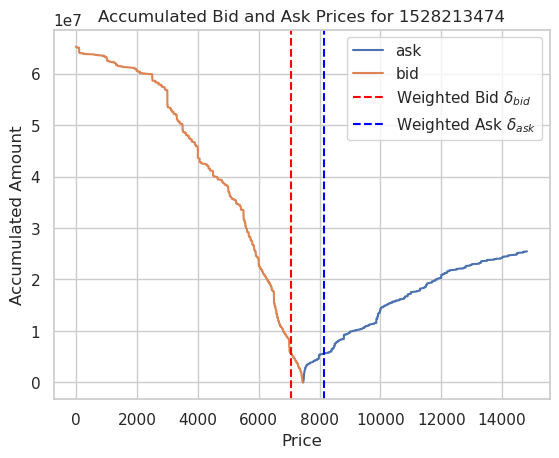

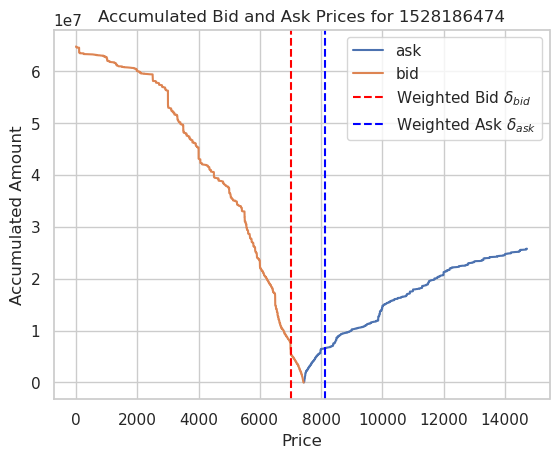

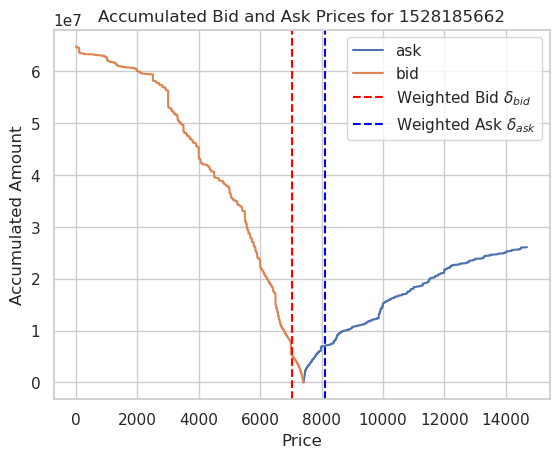

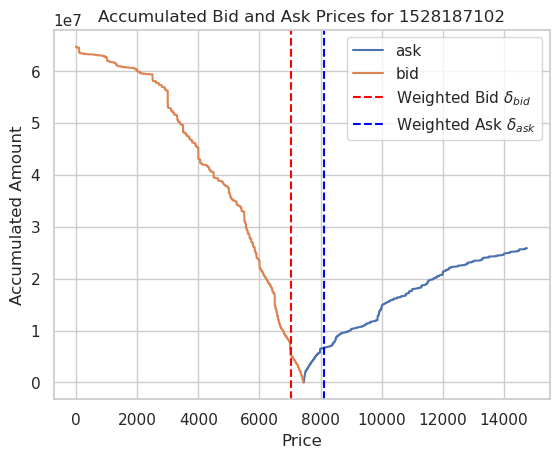

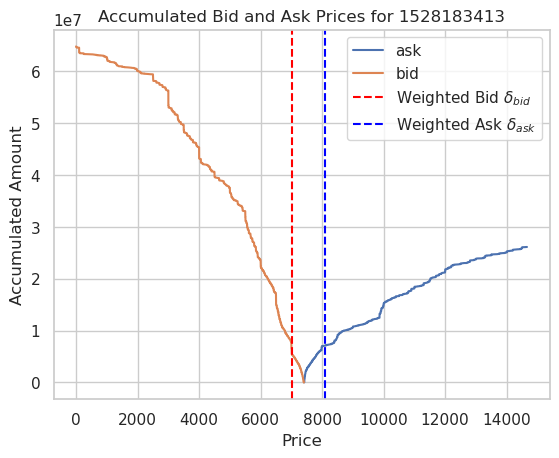

In [57]:
timestamps = np.random.choice(ob_sample['time'].unique(), size=5, replace=False) 


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example(ts)
    sns.lineplot(ask_acc, x='price', y='accumulated_ask', label='ask')
    sns.lineplot(bid_acc, x='price', y='accumulated_bid', label='bid')

    plt.axvline(x=agg_df.filter(pl.col('time') == ts)['weighted_bid'].to_numpy()[0], color='red', linestyle='--', label=r'Weighted Bid $\delta_{bid}$')
    plt.axvline(x=agg_df.filter(pl.col('time') == ts)['weighted_ask'].to_numpy()[0], color='blue', linestyle='--', label=r'Weighted Ask $\delta_{ask}$')

    plt.xlabel('Price')
    plt.ylabel('Accumulated Amount')
    plt.title(f'Accumulated Bid and Ask Prices for {ts}')

    # zoom in
    # plt.xlim(agg_df.filter(pl.col('time') == ts)['weighted_bid'].to_numpy()[0] - 2000, agg_df.filter(pl.col('time') == ts)['weighted_ask'].to_numpy()[0] + 2000)
    plt.legend()
    plt.show()

### Time evolution (over the day)

In [58]:
# sort by time
agg_df = agg_df.sort("time")

<Axes: xlabel='time', ylabel='weighted_spread'>

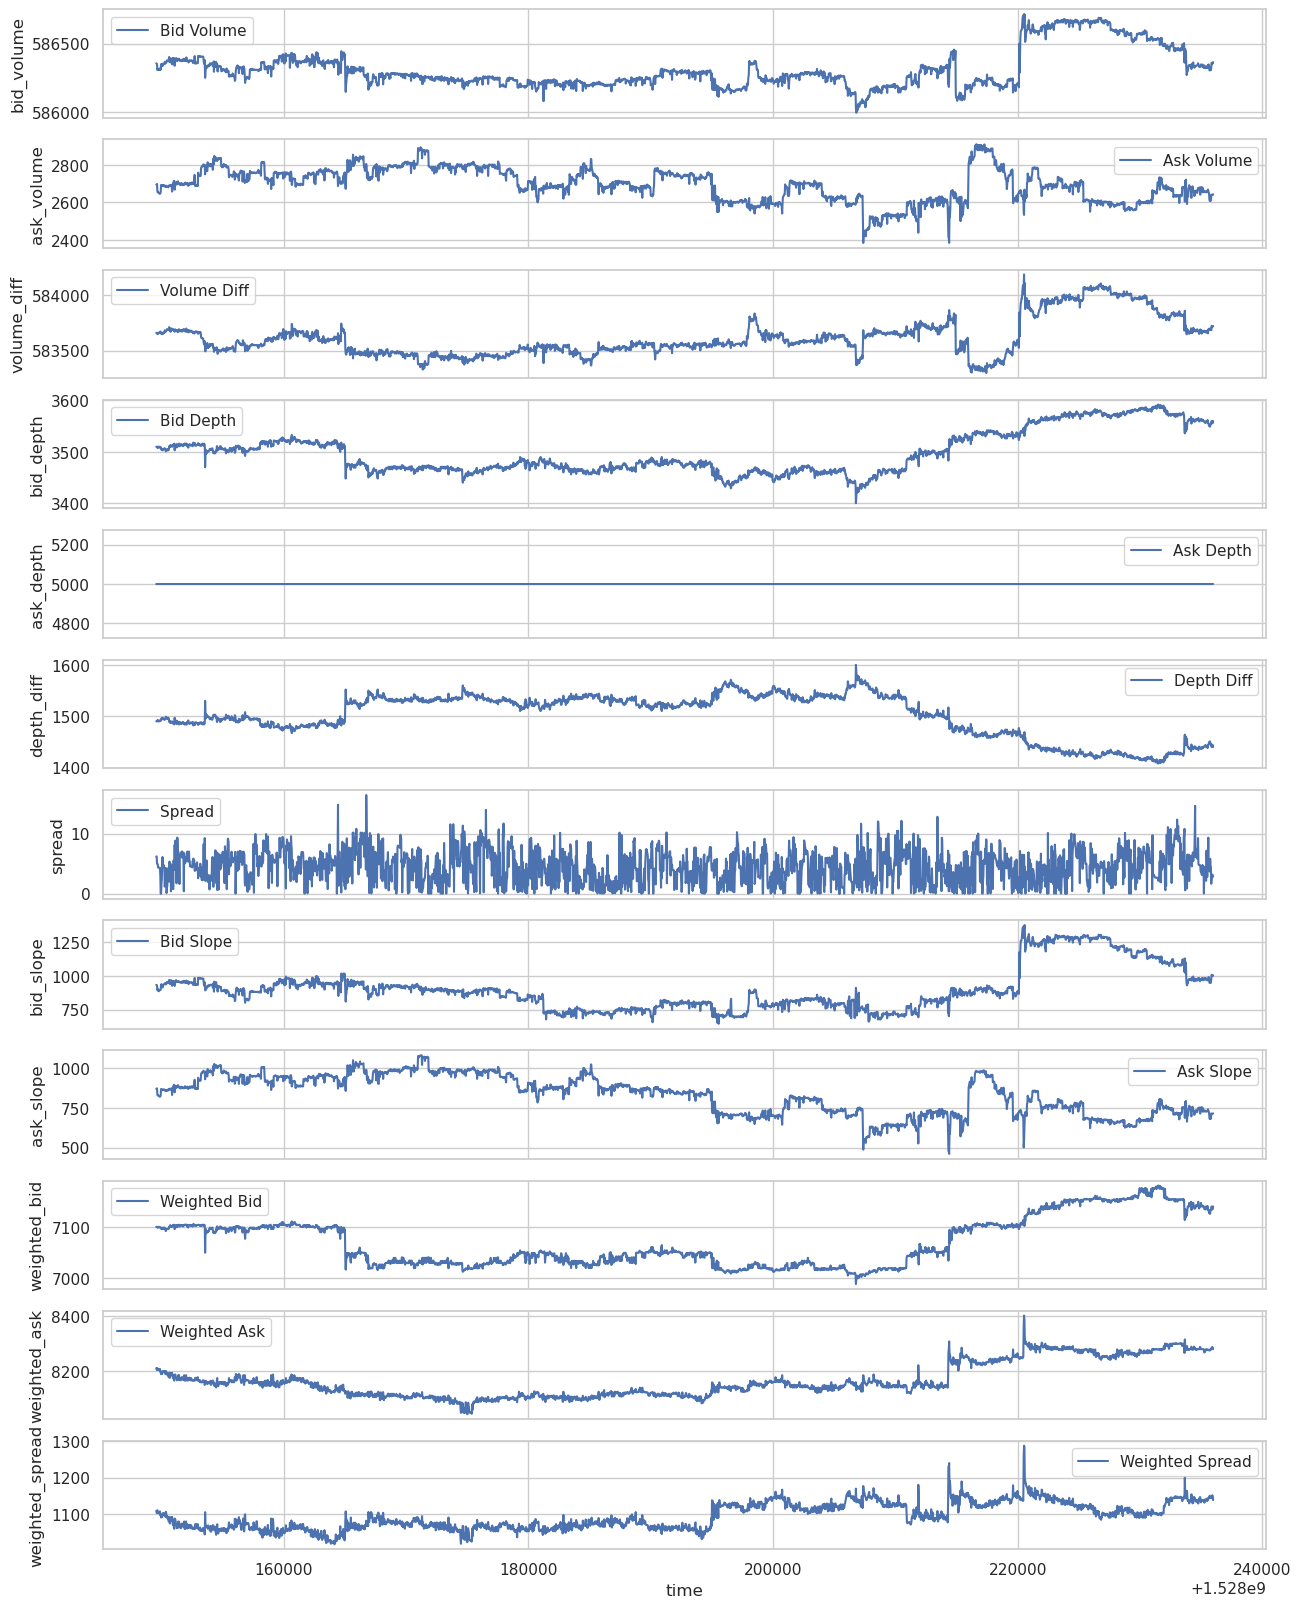

In [59]:
fig, ax = plt.subplots(12, 1, figsize=(15, 20), sharex=True)

# plot bid and ask volume
sns.lineplot(data=agg_df, x='time', y='bid_volume', ax=ax[0], label='Bid Volume')
sns.lineplot(data=agg_df, x='time', y='ask_volume', ax=ax[1], label='Ask Volume')
sns.lineplot(data=agg_df, x='time', y='volume_diff', ax=ax[2], label='Volume Diff')
sns.lineplot(data=agg_df, x='time', y='bid_depth', ax=ax[3], label='Bid Depth')
sns.lineplot(data=agg_df, x='time', y='ask_depth', ax=ax[4], label='Ask Depth')
sns.lineplot(data=agg_df, x='time', y='depth_diff', ax=ax[5], label='Depth Diff')
sns.lineplot(data=agg_df, x='time', y='spread', ax=ax[6], label='Spread')
sns.lineplot(data=agg_df, x='time', y='bid_slope', ax=ax[7], label='Bid Slope')
sns.lineplot(data=agg_df, x='time', y='ask_slope', ax=ax[8], label='Ask Slope')
sns.lineplot(data=agg_df, x='time', y='weighted_bid', ax=ax[9], label='Weighted Bid')
sns.lineplot(data=agg_df, x='time', y='weighted_ask', ax=ax[10], label='Weighted Ask')
sns.lineplot(data=agg_df, x='time', y='weighted_spread', ax=ax[11], label='Weighted Spread')

### Correlations

In [60]:
agg_df

time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth,depth_diff,spread,volume_diff,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
i64,f64,f64,f64,f64,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
1528149602,586356.113693,2695.804973,7537.0,7543.19,3510,5000,1490,6.19,583660.30872,934.466054,868.789883,7100.29,8210.0,1109.71
1528149634,586351.269401,2696.561478,7537.0,7543.19,3510,5000,1490,6.19,583654.707923,929.621762,869.597349,7100.29,8204.47,1104.18
1528149661,586350.938081,2699.165417,7537.0,7541.97,3510,5000,1490,4.97,583651.772664,929.290442,872.151288,7100.29,8203.44,1103.15
1528149693,586307.355517,2656.934508,7537.01,7541.97,3508,5000,1492,4.96,583650.421009,894.15346,829.919417,7099.0,8210.0,1111.0
1528149722,586317.596946,2657.946212,7537.0,7541.9,3509,5000,1491,4.9,583659.650734,903.394889,830.982083,7100.0,8204.47,1104.47
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1528235853,586359.535387,2639.309888,7585.02,7587.61,3560,5000,1440,2.59,583720.225499,1008.843487,711.932457,7140.08,8284.42,1144.34
1528235881,586349.559794,2640.391771,7586.33,7589.52,3557,5000,1443,3.19,583709.168023,1003.168735,713.01434,7134.59,8284.42,1149.83
1528235914,586359.035472,2639.944562,7586.41,7589.52,3557,5000,1443,3.11,583719.09091,1003.242941,712.566581,7134.59,8286.62,1152.03


In [61]:
# compute correlation between features
corr = agg_df.select(
    pl.col('bid_volume'),
    pl.col('ask_volume'),
    pl.col('volume_diff'),
    pl.col('bid_depth'),
    pl.col('spread'),
    # pl.col('ask_depth'), # constant = 5000
    # pl.col('depth_diff'), # = bid_depth - 5000
    pl.col('bid_slope'),
    pl.col('ask_slope'),
    pl.col('weighted_bid'),
    pl.col('weighted_ask'),
    pl.col('weighted_spread'),
).to_pandas().corr()

In [62]:
corr

,bid_volume,ask_volume,volume_diff,bid_depth,spread,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
bid_volume,1.000000,-0.050423,0.855398,0.820543,0.068958,0.925976,-0.197572,0.808730,0.678449,0.137396
ask_volume,-0.050423,1.000000,-0.560444,-0.037563,0.098426,0.059597,0.931411,-0.001329,-0.298424,-0.536333
volume_diff,0.855398,-0.560444,1.000000,0.699914,0.006136,0.736954,-0.646894,0.671327,0.717374,0.392094
bid_depth,0.820543,-0.037563,0.699914,1.000000,0.091296,0.838629,-0.231342,0.983970,0.865939,0.240162
spread,0.068958,0.098426,0.006136,0.091296,1.000000,0.101168,0.086155,0.098157,0.036873,-0.065318
bid_slope,0.925976,0.059597,0.736954,0.838629,0.101168,1.000000,-0.112989,0.822396,0.728448,0.209203
ask_slope,-0.197572,0.931411,-0.646894,-0.231342,0.086155,-0.112989,1.000000,-0.171634,-0.523672,-0.713810
weighted_bid,0.808730,-0.001329,0.671327,0.983970,0.098157,0.822396,-0.171634,1.000000,0.837272,0.166943
weighted_ask,0.678449,-0.298424,0.717374,0.865939,0.036873,0.728448,-0.523672,0.837272,1.000000,0.678890
weighted_spread,0.137396,-0.536333,0.392094,0.240162,-0.065318,0.209203,-0.713810,0.166943,0.678890,1.000000


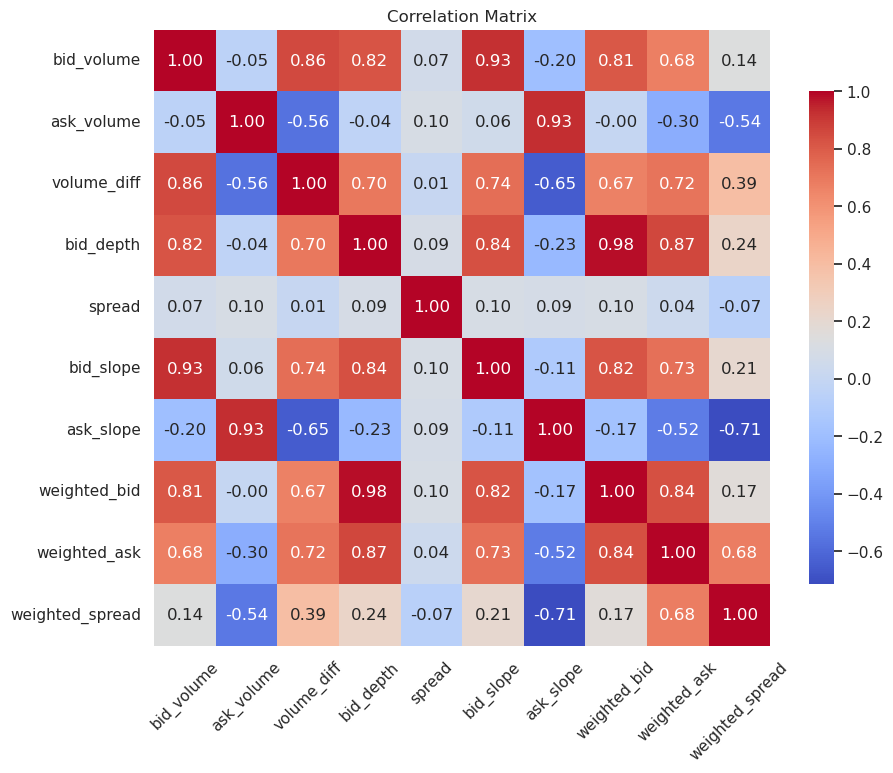

In [63]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.xticks(rotation=45)
plt.title('Correlation Matrix')
plt.show()

In [64]:
cov = agg_df.select(
    pl.col('bid_volume'),
    pl.col('ask_volume'),
    pl.col('volume_diff'),
    pl.col('bid_depth'),
    pl.col('spread'),
    # pl.col('ask_depth'), # constant = 5000
    # pl.col('depth_diff'), # = bid_depth - 5000
    pl.col('bid_slope'),
    pl.col('ask_slope'),
    pl.col('weighted_bid'),
    pl.col('weighted_ask'),
    pl.col('weighted_spread'),
).to_pandas().cov()

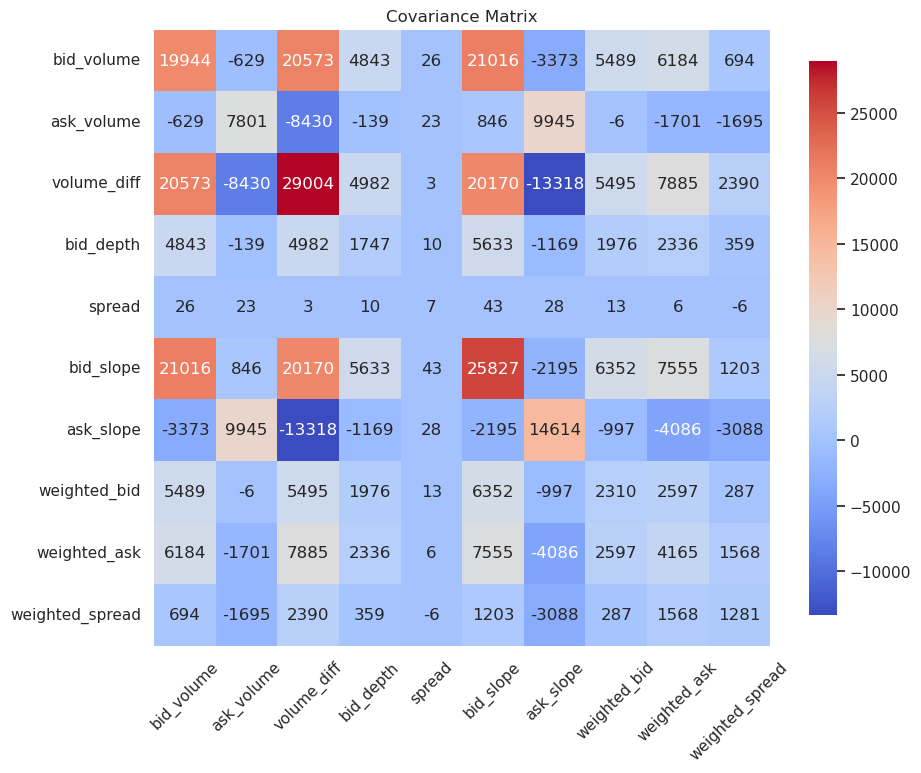

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov, annot=True, cmap='coolwarm', fmt='.0f', square=True, cbar_kws={"shrink": .9})
plt.xticks(rotation=45)
plt.title('Covariance Matrix')
plt.show()

## Conclusions

- `ask_depth` is constant =5000, and `depth_diff` are redundant as it is equal to `bid_depth` - 5000.
- `bid_depth` is inflated by the number of orders with price close to 0. This makes the `bid_depth` less informative about what is happening around the current price. We can address this issue by removing the bid orders with price less then some `bid_price_lower_bound` parameter, e.g. 100 USD 
- `bid_volume` is two orders of magnitude larger than `ask_volume`, but variance of the two are of the same order of magnitude on some days (e.g. 05/06/2018). This is not always the case, because on some days there are very big orders and `bid_volume` can have very large variance (e.g. 21/06 and 15/08). Thus, we will keep both volumes and we will keep the difference between the two as features, but we expect them to be very correlated due to occasional big orders.
- There is no clear pattern in the time evolution of the features, nor in their correlation, on the three example days. On some days, some features are very correlated (>0.9), while on other days they are not correlated at all. Thus no further reduction of the features will be done, at least not on a single timestamp level. 

# Trade data

## Load and format

In [187]:
trx_sample = pd.read_csv(
     data_path / 'bitstamp_trx_05_06_2018.zip'   
)

In [188]:
# fix column names by removing spaces and quotes
trx_sample.columns = [s.replace(' ', '').replace("'", '') for s in trx_sample.columns]

# 'datetime' columns to datetime type 
trx_sample['datetime'] = pd.to_datetime(trx_sample['datetime'])

In [189]:
trx_sample

,timestamp,price,datetime,cost,id,fee,fee1,order,symbol,amount,type,side
0,1528146009000,7522.34,2018-06-04 21:00:09+00:00,550.000553,67680495,{'currency': u'USD','cost': None},None,BTC/USD,0.073116,None,sell
1,1528146009000,7528.99,2018-06-04 21:00:09+00:00,12.735061,67680494,{'currency': u'USD','cost': None},None,BTC/USD,0.001691,None,buy
2,1528146010000,7522.23,2018-06-04 21:00:10+00:00,44.807667,67680496,{'currency': u'USD','cost': None},None,BTC/USD,0.005957,None,sell
3,1528146014000,7528.99,2018-06-04 21:00:14+00:00,169.096523,67680503,{'currency': u'USD','cost': None},None,BTC/USD,0.022459,None,buy
4,1528146014000,7528.99,2018-06-04 21:00:14+00:00,19.498503,67680501,{'currency': u'USD','cost': None},None,BTC/USD,0.002590,None,buy
...,...,...,...,...,...,...,...,...,...,...,...,...
35123,1528235928000,7589.52,2018-06-05 21:58:48+00:00,37.301580,67769918,{'currency': u'USD','cost': None},None,BTC/USD,0.004915,None,buy
35124,1528235942000,7589.52,2018-06-05 21:59:02+00:00,576.788341,67769920,{'currency': u'USD','cost': None},None,BTC/USD,0.075998,None,buy
35125,1528235948000,7586.50,2018-06-05 21:59:08+00:00,2162.956366,67769921,{'currency': u'USD','cost': None},None,BTC/USD,0.285106,None,sell
35126,1528235958000,7589.52,2018-06-05 21:59:18+00:00,261.838440,67769928,{'currency': u'USD','cost': None},None,BTC/USD,0.034500,None,buy


In [190]:
trx_sample.fee.unique()

array([" {'currency': u'USD'"], dtype=object)

In [191]:
trx_sample.fee1.unique()

array([" 'cost': None}"], dtype=object)

In [192]:
trx_sample.order.unique()

array([' None'], dtype=object)

In [193]:
trx_sample.symbol.unique()

array([' BTC/USD'], dtype=object)

In [194]:
trx_sample.type.unique()

array([' None'], dtype=object)

In [195]:
trx_sample.side.unique()

array([' sell', ' buy'], dtype=object)

In [196]:
trx_sample = trx_sample.drop(columns=['fee', 'fee1', 'order', 'symbol', 'type'])


In [197]:
trx_sample.datetime.min(), trx_sample.datetime.max()

(Timestamp('2018-06-04 21:00:09+0000', tz='UTC'),
 Timestamp('2018-06-05 21:59:23+0000', tz='UTC'))

## Compute Volatility

In [206]:
df = trx_sample

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
df.sort_index()

,timestamp,price,cost,id,amount,side
datetime,,,,,,
2018-06-04 21:00:09+00:00,1528146009000,7522.34,550.000553,67680495,0.073116,sell
2018-06-04 21:00:09+00:00,1528146009000,7528.99,12.735061,67680494,0.001691,buy
2018-06-04 21:00:10+00:00,1528146010000,7522.23,44.807667,67680496,0.005957,sell
2018-06-04 21:00:14+00:00,1528146014000,7528.99,169.096523,67680503,0.022459,buy
2018-06-04 21:00:14+00:00,1528146014000,7528.99,19.498503,67680501,0.002590,buy
...,...,...,...,...,...,...
2018-06-05 21:58:48+00:00,1528235928000,7589.52,37.301580,67769918,0.004915,buy
2018-06-05 21:59:02+00:00,1528235942000,7589.52,576.788341,67769920,0.075998,buy
2018-06-05 21:59:08+00:00,1528235948000,7586.50,2162.956366,67769921,0.285106,sell


In [208]:
df.tail()

,timestamp,price,cost,id,amount,side
datetime,,,,,,
2018-06-05 21:58:48+00:00,1528235928000,7589.52,37.301580,67769918,0.004915,buy
2018-06-05 21:59:02+00:00,1528235942000,7589.52,576.788341,67769920,0.075998,buy
2018-06-05 21:59:08+00:00,1528235948000,7586.50,2162.956366,67769921,0.285106,sell
2018-06-05 21:59:18+00:00,1528235958000,7589.52,261.838440,67769928,0.034500,buy
2018-06-05 21:59:23+00:00,1528235963000,7589.52,65.269872,67769929,0.008600,buy


In [211]:
returns = df["price"].pct_change()

In [213]:
returns.isnull().sum()

1

In [214]:
returns = df["price"].pct_change()
returns = returns.dropna()
returns

datetime
2018-06-04 21:00:09+00:00    0.000884
2018-06-04 21:00:10+00:00   -0.000898
2018-06-04 21:00:14+00:00    0.000899
2018-06-04 21:00:14+00:00    0.000000
2018-06-04 21:00:14+00:00    0.000000
                               ...   
2018-06-05 21:58:48+00:00    0.000000
2018-06-05 21:59:02+00:00    0.000000
2018-06-05 21:59:08+00:00   -0.000398
2018-06-05 21:59:18+00:00    0.000398
2018-06-05 21:59:23+00:00    0.000000
Name: price, Length: 35127, dtype: float64

In [230]:
vol = (returns**2).resample("h").sum().rename("vol") 
std = (returns).resample("h").std().rename("std")
count = (returns).resample("h").count().rename("count_ticks")
ret = returns.add(1).resample("h").prod().add(-1).rename("ret")
hourly = pd.merge(vol, std, left_index=True, right_index=True, how="outer")
hourly = pd.merge(hourly, ret, left_index=True, right_index=True, how="outer")
hourly = pd.merge(hourly, count, left_index=True, right_index=True, how="outer")
hourly

,vol,std,ret,count_ticks
datetime,,,,
2018-06-04 21:00:00+00:00,0.000161,0.000357,0.002758,1261
2018-06-04 22:00:00+00:00,0.000076,0.000329,-0.005051,699
2018-06-04 23:00:00+00:00,0.000152,0.000379,-0.002229,1065
2018-06-05 00:00:00+00:00,0.000111,0.000372,0.001552,807
2018-06-05 01:00:00+00:00,0.000092,0.000294,-0.001719,1069
2018-06-05 02:00:00+00:00,0.000517,0.000476,-0.010899,2279
2018-06-05 03:00:00+00:00,0.000148,0.000378,0.000408,1036
2018-06-05 04:00:00+00:00,0.000178,0.000371,-0.004410,1294
2018-06-05 05:00:00+00:00,0.000169,0.000387,0.006927,1131


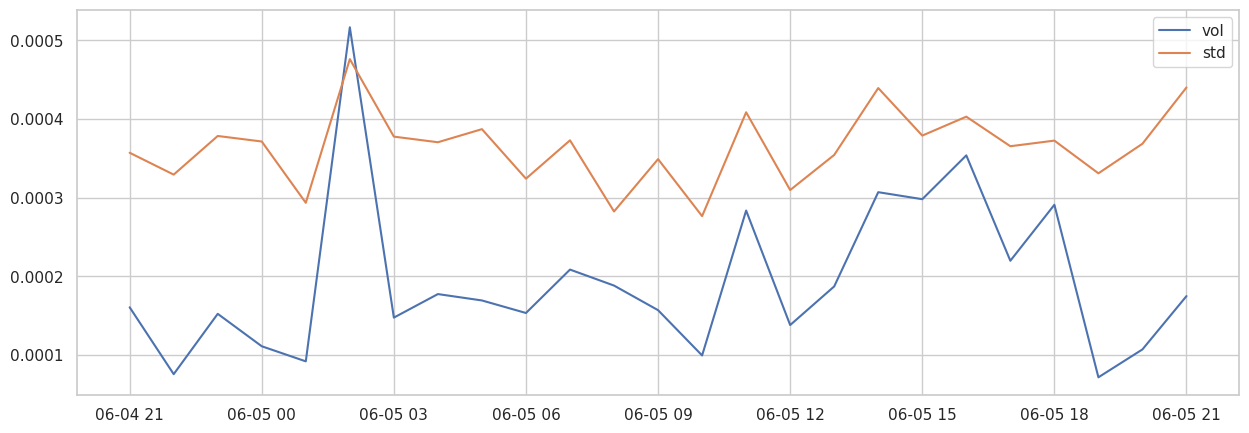

In [231]:
plt.figure(figsize=(15, 5))

plt.plot(hourly.index, hourly["vol"], label="vol")
plt.plot(hourly.index, hourly["std"], label="std")
plt.legend()

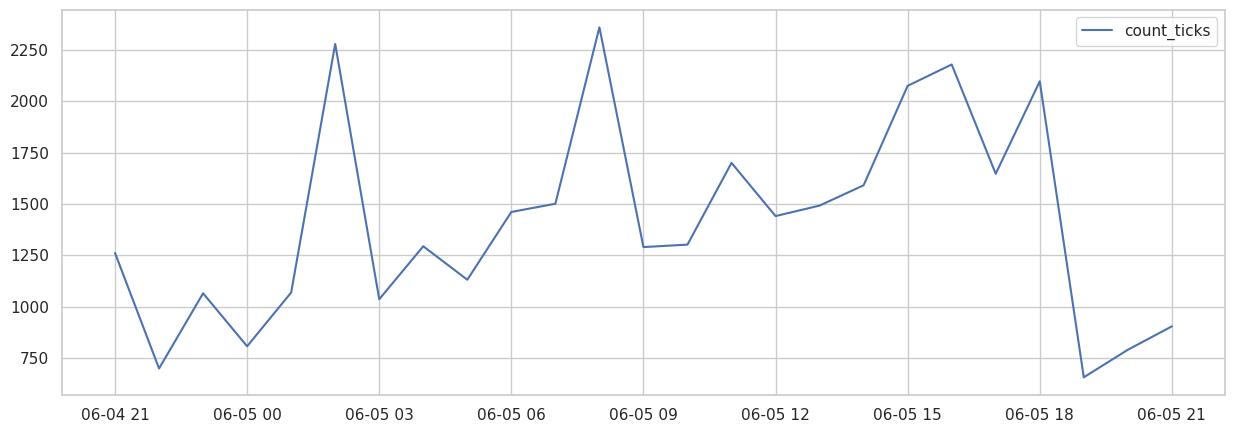

In [232]:
plt.figure(figsize=(15, 5))

plt.plot(hourly.index, hourly["count_ticks"], label="count_ticks")
plt.legend()

## Conclusions

- `(returns**2).resample("h").sum()` sums squared returns over an hourly windows, but the number of ticks is not constant. Thus `(returns).resample("h").std()` will be used.
